In [1]:
import librosa
import soundfile as sf

def normalize_audio(filepath, target_rms=0.1):
    audio, sr = librosa.load(filepath, sr=None)
    rms = (audio ** 2).mean() ** 0.5
    scaling_factor = target_rms / rms
    normalized_audio = audio * scaling_factor
    sf.write(filepath, normalized_audio, sr)

# normalize_audio("ID_1_level2_పట్ట.wav")
# normalize_audio("ID_1_level2_బట్ట.wav")
normalize_audio("ID_1_level1__k_.wav")
normalize_audio("ID_1_level1__g_.wav")


In [26]:


def split_audio(file_path, segment_duration=6, sr=16000):
    y, _ = librosa.load(file_path, sr=sr)
    segment_length = segment_duration * sr
    segments = [y[i:i + segment_length] for i in range(0, len(y), segment_length)]
    return segments

# # Example usage
a_segments = split_audio("ID_1_level2_పట్ట.wav")
b_segments = split_audio("ID_1_level2_బట్ట.wav")
# a_segments = split_audio("ID_1_level1__p_.wav")
# b_segments = split_audio("ID_1_level1__b_.wav")
# c_segments = split_audio("word_C.wav")


In [27]:
import numpy as np

In [28]:
def extract_features(y, sr=16000):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfccs, axis=1)

# Extract features for each segment
a_features = [extract_features(segment) for segment in a_segments]
b_features = [extract_features(segment) for segment in b_segments]
# c_features = [extract_features(segment) for segment in c_segments]


In [29]:
from scipy.spatial.distance import cosine

def compare_features(features1, features2):
    similarities = []
    for f1 in features1:
        for f2 in features2:
        # if f1 not equal to f2
            similarity = 1 - cosine(f1, f2)  # Cosine similarity
            similarities.append(similarity)
    return similarities

# Compare each segment from A with all segments from B and C
a_vs_b_similarities = compare_features(a_features, b_features)
a_vs_a_similarities = compare_features(a_features, a_features)


In [30]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def compare_features_dtw(features1, features2):
    dtw_distances = []
    for f1 in features1:
        for f2 in features2:
            # Calculate the DTW distance between f1 and f2
            distance, path = fastdtw(f1, f2, dist=euclidean)
            dtw_distances.append(distance)
    return dtw_distances


# Compare each segment from A with all segments from B and C
a_vs_b_similarities_dtw = compare_features_dtw(a_features, b_features)
a_vs_a_similarities_dtw = compare_features_dtw(a_features, a_features)

In [31]:
def compute_spectrogram(signal, sr=16000, n_fft=2048, hop_length=512):
    # Compute the Short-Time Fourier Transform (STFT) to get the spectrogram
    spectrogram = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    # Convert the amplitude to decibels
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
    # Transpose the spectrogram so that time is on the x-axis
    return spectrogram_db.T

def compare_spectrograms_dtw(spectrograms1, spectrograms2):
    dtw_distances = []
    for s1 in spectrograms1:
        for s2 in spectrograms2:
            # Calculate the DTW distance between s1 and s2
            distance, path = fastdtw(s1, s2, dist=euclidean)
            dtw_distances.append(distance)
    return dtw_distances


a_spectrograms = [compute_spectrogram(segment) for segment in a_segments]
b_spectrograms = [compute_spectrogram(segment) for segment in b_segments]

# Compare the spectrogram of A with B
a_vs_b_similarities_dtw_spec = compare_spectrograms_dtw(a_spectrograms, b_spectrograms)

# Compare the spectrogram of A with itself
a_vs_a_similarities_dtw_spec = compare_spectrograms_dtw(a_spectrograms, a_spectrograms)

In [32]:
def find_best_matches(a_features, b_features, a_vs_b_similarities, a_vs_a_similarities):
    best_matches = []
    for i in range(len(a_features)):
        # Best match of the i-th segment of A with all segments of B
        start_idx_b = i * len(b_features)
        end_idx_b = (i + 1) * len(b_features)
        best_match_b = max(a_vs_b_similarities[start_idx_b:end_idx_b], default=-1)

        # Best match of the i-th segment of A with other segments of A
        start_idx_a = i * len(a_features)
        end_idx_a = (i + 1) * len(a_features)
        best_match_a = max([sim for j, sim in enumerate(a_vs_a_similarities[start_idx_a:end_idx_a]) if i != j], default=-1)

        # Determine if the best match is from B or from A
        best_match_source = 'B' if best_match_b > best_match_a else 'A'
        best_matches.append((best_match_b, best_match_a, best_match_source))
    
    return best_matches

# Find best matches
best_matches = find_best_matches(a_features, b_features, a_vs_b_similarities, a_vs_a_similarities)

# Output results
for i, (best_match_b, best_match_a, best_match_source) in enumerate(best_matches):
    print(f"Segment {i} of A:")
    print(f"  Best match with B: {best_match_b}")
    print(f"  Best match with other A segments: {best_match_a}")
    print(f"  Best match source: {best_match_source}")


Segment 0 of A:
  Best match with B: 0.9993976354598999
  Best match with other A segments: 0.999320924282074
  Best match source: B
Segment 1 of A:
  Best match with B: 0.9998534917831421
  Best match with other A segments: 0.9996557831764221
  Best match source: B
Segment 2 of A:
  Best match with B: 0.9998974204063416
  Best match with other A segments: 0.9996557831764221
  Best match source: B


In [33]:
def find_best_matches_dtw(a_features, b_features, a_vs_b_similarities, a_vs_a_similarities):
    best_matches = []
    for i in range(len(a_features)):
        # Best match of the i-th segment of A with all segments of B
        start_idx_b = i * len(b_features)
        end_idx_b = (i + 1) * len(b_features)
        best_match_b = min(a_vs_b_similarities[start_idx_b:end_idx_b], default=-1)

        # Best match of the i-th segment of A with other segments of A
        start_idx_a = i * len(a_features)
        end_idx_a = (i + 1) * len(a_features)
        best_match_a = min([sim for j, sim in enumerate(a_vs_a_similarities[start_idx_a:end_idx_a]) if i != j], default=-1)

        # Determine if the best match is from B or from A
        best_match_source = 'B' if best_match_b < best_match_a else 'A'
        best_matches.append((best_match_b, best_match_a, best_match_source))
    
    return best_matches
best_matches_dtw = find_best_matches_dtw(a_features, b_features, a_vs_b_similarities_dtw, a_vs_a_similarities_dtw)

# Output results
for i, (best_match_b, best_match_a, best_match_source) in enumerate(best_matches_dtw):
    print(f"Segment {i} of A:")
    print(f"  Best match with B: {best_match_b}")
    print(f"  Best match with other A segments: {best_match_a}")
    print(f"  Best match source: {best_match_source}")


Segment 0 of A:
  Best match with B: 33.49068185687065
  Best match with other A segments: 44.217312663793564
  Best match source: B
Segment 1 of A:
  Best match with B: 28.39561375975609
  Best match with other A segments: 43.39099605381489
  Best match source: B
Segment 2 of A:
  Best match with B: 16.242564111948013
  Best match with other A segments: 43.39099605381489
  Best match source: B


In [34]:
def find_best_matches_dtw(a_features, b_features, a_vs_b_similarities, a_vs_a_similarities):
    best_matches = []
    for i in range(len(a_features)):
        # Best match of the i-th segment of A with all segments of B
        start_idx_b = i * len(b_features)
        end_idx_b = (i + 1) * len(b_features)
        best_match_b = min(a_vs_b_similarities[start_idx_b:end_idx_b], default=-1)

        # Best match of the i-th segment of A with other segments of A
        start_idx_a = i * len(a_features)
        end_idx_a = (i + 1) * len(a_features)
        best_match_a = min([sim for j, sim in enumerate(a_vs_a_similarities[start_idx_a:end_idx_a]) if i != j], default=-1)

        # Determine if the best match is from B or from A
        best_match_source = 'B' if best_match_b < best_match_a else 'A'
        best_matches.append((best_match_b, best_match_a, best_match_source))
    
    return best_matches
best_matches_dtw_spec = find_best_matches_dtw(a_features, b_features, a_vs_b_similarities_dtw_spec, a_vs_a_similarities_dtw_spec)

# Output results
for i, (best_match_b, best_match_a, best_match_source) in enumerate(best_matches_dtw_spec):
    print(f"Segment {i} of A:")
    print(f"  Best match with B: {best_match_b}")
    print(f"  Best match with other A segments: {best_match_a}")
    print(f"  Best match source: {best_match_source}")


Segment 0 of A:
  Best match with B: 22202.090913729477
  Best match with other A segments: 21451.410973775644
  Best match source: A
Segment 1 of A:
  Best match with B: 17522.249142501878
  Best match with other A segments: 15434.894982686325
  Best match source: A
Segment 2 of A:
  Best match with B: 14717.083887289406
  Best match with other A segments: 15434.894982686325
  Best match source: B


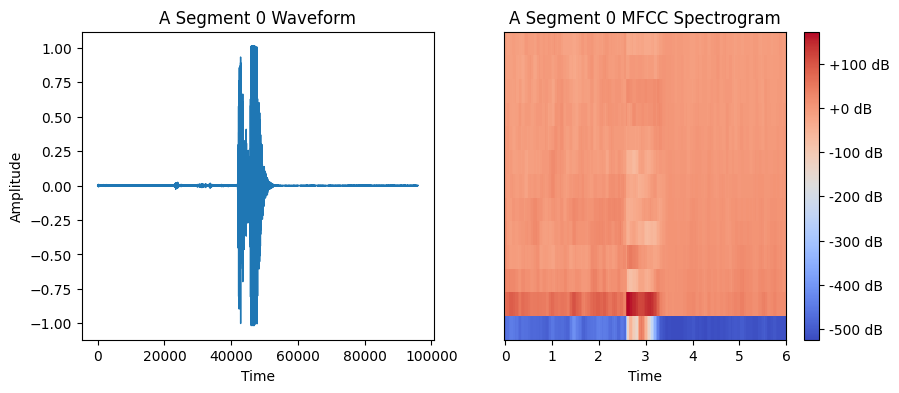

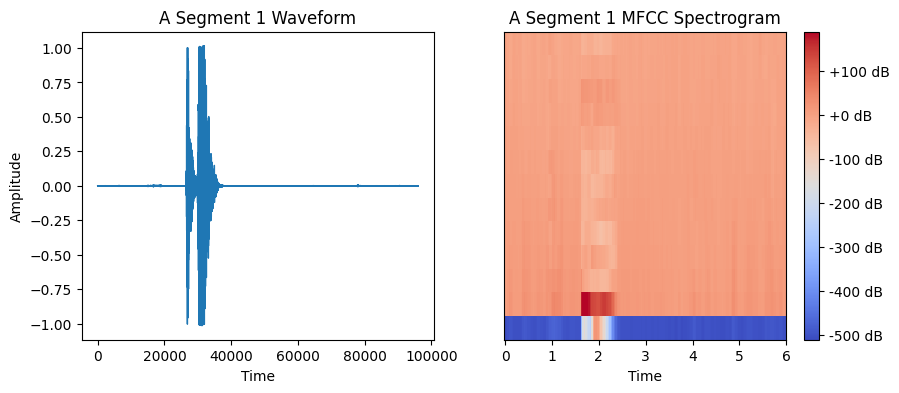

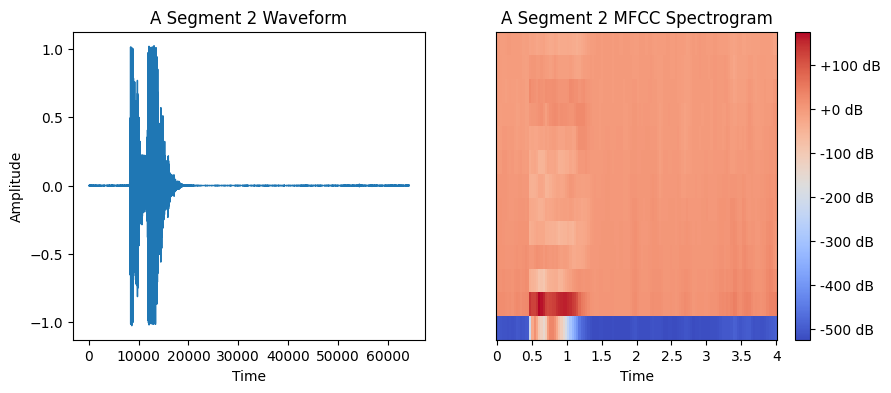

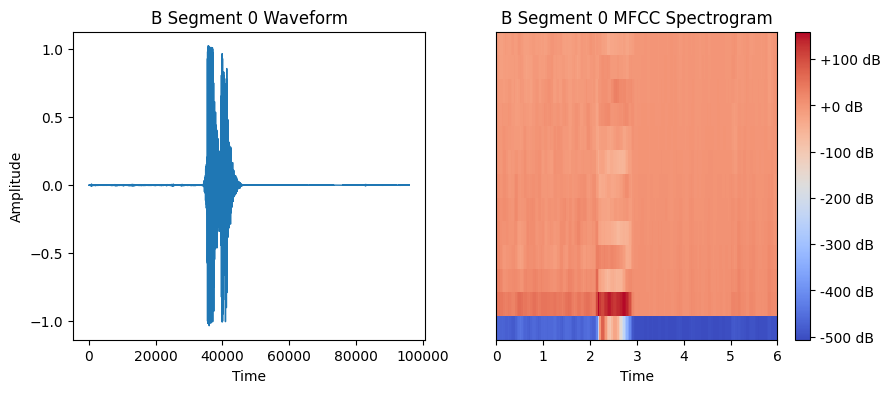

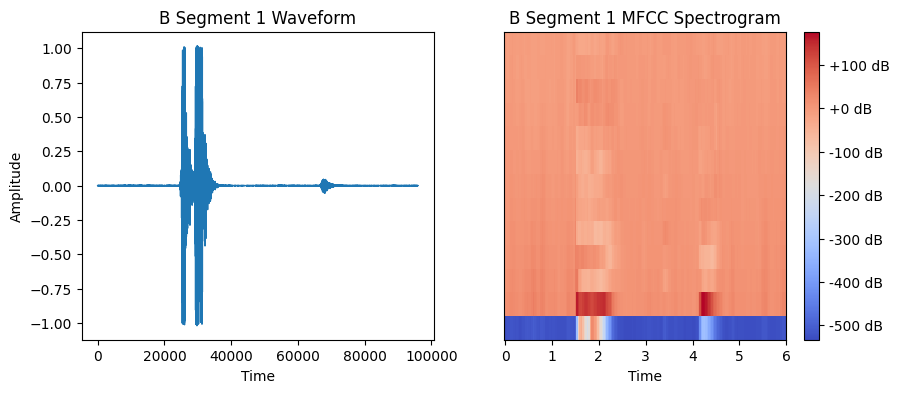

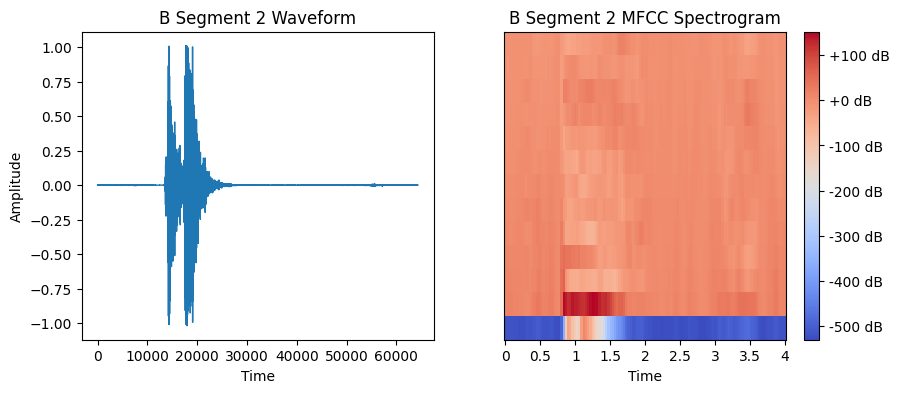

In [35]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def extract_features(y, sr=16000):
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs


def plot_features(segments, label):
    for i, segment in enumerate(segments):
        mfccs = extract_features(segment)
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(segment, lw=1)
        plt.title(f"{label} Segment {i} Waveform")
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        
        plt.subplot(1, 2, 2)
        librosa.display.specshow(mfccs, sr=16000, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{label} Segment {i} MFCC Spectrogram")
        plt.show()


plot_features(a_segments, "A")
plot_features(b_segments, "B")
